#  <b>Projekt - Wykrywanie spamu</b>
## Na przedmiot: _Metody analizy danych_

## Użyta metoda analizy danych: Klasyfikacja (Support vector machine, Naive Bayes, Decision tree)

<br>

Autorzy:
- Jakub Zawadzki  217576
- Patryk Zawadzki 217565
- Paweł Hebda     217626
- Marcin Galewski 220252

# Słowa Kluczowe

Klasyfikacja, spam, e-mail, Naive Bayes, SVM, Decision tree

# Streszczenie

W naszej pracy analizie został poddany ogólnodostępny zbiór wiadomości e-mail, w którym znajdowały się treści zarówno prawdziwych maili, jak i wiadomości śmieciowych (spam).

Opisany zbiór danych jest zapisany w postaci pliku .csv gdzie w każdym rekordzie znajduje się informacje o treści maila i typie wiadomości (spam/nie spam). Zapisane treści w postaci tekstu, aby móc przetworzyć dane w takiej postaci, należy przygotować je wcześniej do obliczeń poprzez wykorzystanie tokenizacji, lemanizacji i usunięciu tak zwanych "Stop words". Wszystkie te kroki zawraliśmy również w naszej pracy.

Następnie tak przygotowane dane zostaną poddane wektoryzacji tfid. Dopiero tak uzyskany wektor będzie wykorzystany do wytrenowania modeli za pomocą metod: SVM, Naive Bayes, Drzewo decyzyjne oraz metoda hybrydowa.

Na końcu wyniki z powyższych metod zostaną porównane ze sobą.

# Wprowadzenie

_Oprogramowanie do wykrywania spamu_, znane również jako filtr antyspamowy, działa na serwerze pocztowym lub komputerze użytkownika i sprawdza skrzynkę odbiorczą w celu wykrycia potencjalnych wiadomości spamowych. Podobnie jak w przypadku tradycyjnych skrzynek pocztowych, skrzynka odbiorcza jest miejscem docelowym przychodzących wiadomości e-mail. Detektor spamu ma zazwyczaj swobodny dostęp do tej skrzynki i może przeprowadzać dziesiątki, setki, a nawet tysiące kontroli, aby zdecydować, czy przychodząca wiadomość e-mail jest spamem. Na szczęście wykrywanie spamu jest wszechobecną technologią, która filtruje nieistotną i potencjalnie niebezpieczną korespondencję elektroniczną. Dzięki niej wiele użytkowników jest w stanie uniknąć bycia ofiarą cyberprzestępstwa.

W naszej pracy od podstaw wdrożymy algorytm do wykrywania spamu, sprawdzamy jego dokładność i przedstawimy różne techniki związane z przetwarzaniem języka naturalnego.

# Cel

Naszym celem będzie znalezienie metody, która zwróci nam jak najmniej błędnych klasyfikacji.

# Przygotowanie środowiska

Przygotowanie wszystkich potrzebnych bibliotek i zdefiniowanie funkcji pomocniczych.

In [2]:
import sys
import subprocess
%pip install setuptools
import pkg_resources 
import re

# Sprawdź, które pakiety brakują.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'matplotlib', 'wordcloud', 'scikit-learn', 'nltk'}
missing_packages = required_packages - installed_packages

# Jeśli brakuje pakietów, zainstaluj je.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)
import nltk
nltk.download('wordnet')
nltk.download('punkt')

def clean_text(text):
    text=text.lower()
    # Usuń 'subject:' z początku każdego rekordu.
    text = re.sub('re :', '', text)
    # Usuń wszystko od '-------forwarded by' do 'subject:', gdzie liczba '-' może być różna.
    text = re.sub('- - - -.*forwarded by.*?(?=subject)', '', text,flags=re.DOTALL)
    text = re.sub('enron on.* - - -.*?(?=to :)', '', text,flags=re.DOTALL)
    text = re.sub('sender :.*?(?=subject :)', '', text,flags=re.DOTALL)
    # Usuń wszystko od 'do:' do 'cc:'.
    text = re.sub('to :.*?(?=cc :)', '', text,flags=re.DOTALL)
    # Usuń wszystko od 'cc:' do 'subject:'.
    text = re.sub('cc :.*?(?=subject :)', '', text,flags=re.DOTALL)
    text = re.sub('from :.*?(?=subject :)', '', text,flags=re.DOTALL)
    text = re.sub('(subject :|subject:)', '', text)
    text = re.sub(r'\b\w\b', '', text)
    return text

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_32896/103891041.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Wstępna analiza danych

## Dobór zmiennych

Jako że metody klasyfikacji użyte w naszej pracy wymagają, aby dane wejściowe były ustruktoryzowane w formie wierszy (rekordów) i cech (kolumn), uznaliśmy że każde słowo występujące w naszym zbiorze treningowym danych będzie oznaczało oddzielną cechę. Wartościami w wierszach jest liczba wystąpień danego słowa w danym mailu.

Istnieją zarówno wady, jak i zalety takiego przygotowania danych.

**Zalety:**
- możliwość użycia znanych i sprawdzonych metod klasyfikacyjnych
- proste przygotowanie danych do klasyfikacji

**Wady:**
- duża złożoność obliczeniowa dla niektórych metod, spowodowana dużą liczbą zmiennych
- niższa dokładność, niż przy zastosowaniu na przykład sieci neuronowych

## Chmury wyrazów

W procesie tworzenia filtra antyspamowego możemy przeanalizować treść wiadomości i sprawdzić, czy niektóre słowa pojawiają się częściej? Intuicyjnie, takie słowa mogą służyć do oddzielenia dwóch typów wiadomości e-mail. Łatwym sposobem wykonania tego zadania jest wizualizacja treści wiadomości za pomocą chmur wyrazów. W tej technice wizualizacji często występujące słowa w zbiorze danych (z wyłączeniem wyrazów funkcyjnych, zaimków i kilku innych przypadków) pojawiają się jako większe niż te rzadkie.

Jedną z możliwych implementacji chmur wyrazów w Pythonie jest biblioteka [word_cloud module](https://github.com/amueller/word_cloud).

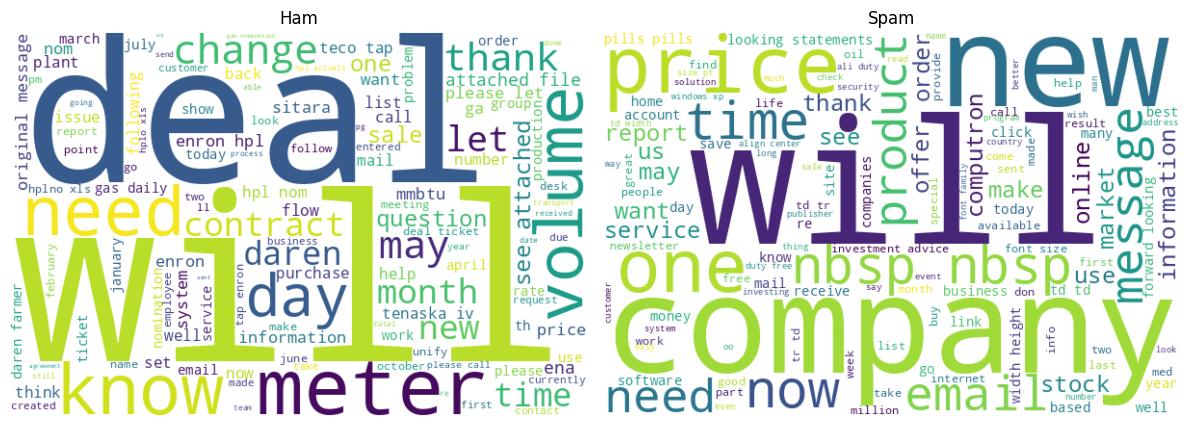

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# Wczytywanie danych i usuwanie niepotrzebnego tekstu
dane = pd.read_csv('spam_ham_dataset.csv')
dane['text']=dane['text'].apply(clean_text)

# Oddzielenie spam od ham
ham_emails = [email for email, label in zip(dane['text'],dane['label']) if label == 'ham']
spam_emails = [email for email, label in zip(dane['text'],dane['label']) if label == 'spam']

# Tworzenie chmury wyrazów
n = 10 # liczba słów

# Dla hamu
ham_text = ' '.join(ham_emails)
ham_wordcloud = WordCloud(background_color="white", width=600, height=400, max_words=125).generate(ham_text)

# Dla spamu
spam_text = ' '.join(spam_emails)
spam_wordcloud = WordCloud(background_color="white", width=600, height=400, max_words=125).generate(spam_text)

# Wyświetlanie chmury
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title("Ham")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title("Spam")
plt.axis("off")

plt.tight_layout()
plt.show()

Na powyższych obrazkach widać, że dla Spam i Ham niektóre wyrazy się powtarzają. Na przykład dla obu najczęstrzym wyrazem jest "will" ale inne wyrazy różnią się co do częstotliwości, co można wykorzystać do klasyfikacji e-maili. Dla e-maili typu "spam" widać na przykład, że często powtarza się słowo "company" (zapewne są to maile phishingowe, kierowane do pracowników), albo wiele znaków "nbsp" ("non-breaking space").

Warto zauważyć, że techniki takie jak chmury wyrazów są powszechne w problemach uczenia maszynowego do eksploracji danych tekstowych przed zastosowaniem dowolnego rozwiązania. Proces ten nazywamy `analizą eksploracyjną danych` (EDA). EDA pozwala zrozumieć, w jaki sposób kierować dalszą analizą, a podstawowym narzędziem do tego zadania są metody wizualizacji.

## Statystyki

In [3]:
from scipy.stats import skew
import numpy as np
import pandas as pd

# Oblicz długość każdego e-maila
def statystyki(maile):
    email_lengths = [len(email) for email in maile]
    return [np.mean(email_lengths),
            np.median(email_lengths),
            np.min(email_lengths),
            np.max(email_lengths),
            np.std(email_lengths),
            skew(email_lengths)]

# Przykładowe dane
tabelka = {
'':['Średnia','Mediana','Minimum','Maksimum','Odchylenie standardowe','Skośność'],
'ogólnie':statystyki(dane['text']),
'spam':statystyki(spam_emails),
'ham':statystyki(ham_emails),
}

display(pd.DataFrame(tabelka).style.hide())

,ogólnie,spam,ham
Średnia,841.250822,1200.563042,694.570806
Mediana,444.000000,550.000000,408.000000
Minimum,3.000000,3.000000,10.000000
Maksimum,22064.000000,22064.000000,16143.000000
Odchylenie standardowe,1276.696277,1808.168280,941.510868
Skośność,4.867795,3.597496,5.414015


W powyższej tabeli zostały opisane statystyki dotyczące naszych przetworzonych danych (liczby wystąpień danego słowa w mailu)

Skośność to miara asymetrii rozkładu prawdopodobieństwa. 

Wartość skośności może być dodatnia lub ujemna, lub nawet niezdefiniowana:

- Jeśli skośność jest mniejsza od zera, dane są lewostronnie skośne i większość wartości jest większa od średniej.
- Jeśli skośność jest równa zero, dane są symetryczne, chociaż niekoniecznie normalne.
- Jeśli skośność jest większa od zera, dane są prawostronnie skośne.

Wartość skośności wynosi 4.42, co jest dużo większe od zera. To sugeruje, że długości e-maili są prawostronnie skośne, co oznacza, że większość e-maili ma długość mniejszą od średniej, a długie e-maile są rzadkością. W takim przypadku, mediana będzie mniejsza od średniej.

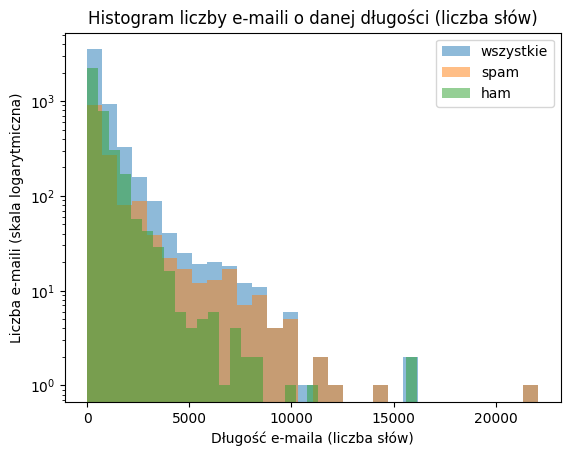

In [4]:
import matplotlib.pyplot as plt

# Histogramy dla każdej serii na tym samym wykresie
plt.hist([len(email) for email in dane['text']], bins=30, alpha=0.5, label='wszystkie', log=True)
plt.hist([len(email) for email in spam_emails], bins=30, alpha=0.5, label='spam', log=True)
plt.hist([len(email) for email in ham_emails], bins=30, alpha=0.5, label='ham', log=True)

plt.title("Histogram liczby e-maili o danej długości (liczba słów)")
plt.xlabel("Długość e-maila (liczba słów)")
plt.ylabel("Liczba e-maili (skala logarytmiczna)")
plt.legend(loc='upper right')
plt.show()

## Braki danych

Jako, że w naszym projekcie potrzbny jest sam email i jego orginalna klasyfikacja to nasz zbiór danych nie zawiera żadnych braków danych

# Przygotowanie danych

W naszej pracy korzystamy z podzbioru zbioru wiadomości e-mail z platformy Kaggle.

Terminem określającym przeciwieństwo wiadomości spamowych jest "ham" (szynka), ponieważ oba słowa są związane z produktami mięsnymi (spam odnosi się do konserwowej szynki, ham do surowej).
Na początku czytamy wiadomości dla obu kategorii (ham i spam) i losowo dzielimy je na grupy treningowe i testowe. Zasadniczo możemy wybrać podział 75:25 między dwoma zestawami, przypisując większą część danym treningowym.

Następnie tokenizujemy te wiadomości, aby podzielić je na oddzielne wyrazy oraz żeby z nich usunąć znaki interpunkcyjne. Usuwamy również tak zwane "stop words" czyli bardzo często występujące słowa w języku angielskim, które wymaga gramatyka tego języka. Są to na przykład słowa: "the", "is", "a", które nie powinny mieć prawie żadnego wpływu na klasyfikacje wiadomości. Potem lematyzujemy słowa czyli przekształcamy słowa na przykład formę liczby mnogiej: "parties" na "party" aby formy danego słowa nie były liczone oddzielnie. Na koniec złączamy słowa spowrotem w całość i uzyskujemy tak wygenerowaną wiadomość.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer

# Załaduj dane.
dane = pd.read_csv('spam_ham_dataset.csv')
dane['text'] = dane['text'].apply(clean_text)

# Podziel dane na zbiory treningowy i testowy.
train_data, test_data, train_class, test_class = train_test_split(dane['text'], dane['label_num'], random_state=123)

# Tokenizuj dane treningowe/testowe. Czyli zmiana całych maili na pojedyńcze słowa
train_data = [word_tokenize(email) for email in train_data]
test_data = [word_tokenize(email) for email in test_data]

# Usunięcie znaków interpunkcyjnych takich jak ":" lub "("
train_data = [[word for word in email if word.isalpha()] for email in train_data]
test_data = [[word for word in email if word.isalpha()] for email in test_data]

# Usunięcie tak zwanych "stop words" czy słowa typu "the", "is", "a"
train_data = [[word for word in email if word not in ENGLISH_STOP_WORDS] for email in train_data]
test_data = [[word for word in email if word not in ENGLISH_STOP_WORDS] for email in test_data]

# Stwórz lematyzer.
lemmatizer = WordNetLemmatizer()

# Lematyzuj tekst.
train_data = [[lemmatizer.lemmatize(word) for word in email] for email in train_data]
test_data = [[lemmatizer.lemmatize(word) for word in email] for email in test_data]

# Odtwórz dane.
train_data = [" ".join(i) for i in train_data]
test_data = [" ".join(i) for i in test_data]

Kontynuujemy ekstrakcją cech dla każdego zdania w obu zestawach. Ten krok wykorzystuje wektorizację tf-idf, po uprzednim wtrenowaniu wektoryzera na danych treningowych.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Stwórz wektorizer.
vectorizer_tfid = TfidfVectorizer()
vectorizer_count = CountVectorizer()

# Dopasuj do danych treningowych.
vectorizer_tfid.fit(train_data)
vectorizer_count.fit(train_data)

# Przekształć dane testowe/treningowe na cechy.
train_data_features_tfid = vectorizer_tfid.transform(train_data)
test_data_features_tfid = vectorizer_tfid.transform(test_data)

train_data_features_count = vectorizer_count.transform(train_data)
test_data_features_count = vectorizer_count.transform(test_data)

print(train_data_features_tfid.shape)

(3878, 35178)


Każda z *3878* wiadomości email w zestawie treningowym jest reprezentowana przez wektor cech o rozmiarze *35178* gdzie każda cechą jest unikatowe słowo w znalezione w email treningowych.

## Wybór metod do klasyfikacji Spamu

Metody używate w naszej pracy zostały wybrane z artykułu "A systematic literature review on spam content detection and classification" napisanego przez Sanaa Kaddoura,Ganesh Chandrasekaran, Daniela Elena Popescu i Jude Hemanth Duraisamy w 2022

> Based on the prior work on spam classification with Machine Learning approaches presented in Table 13, we can conclude that Machine Learning techniques are highly valued by researchers for their importance in spam text classification. Machine learning has the ability to adapt to changing conditions, and it can help overcome the limitations of rule-based spam filtering techniques. Support Vector Machines (SVM), a supervised learning model that analyses data and identifies patterns for classification, is among the most significant machine learning techniques. SVMs are straightforward to train, and some researchers assert that they outperform many popular social media spam classification methods. However, due to the computational complexities of the data input, the resilience and usefulness of SVM for high dimension data shrinks over time. Another machine learning algorithm that has been successfully used to detect spam in social media text is the decision tree. When it comes to training datasets, decision trees (DT) require very little effort from users. They suffer from certain disadvantages, such as the complexity of controlling tree growth without proper pruning and their sensitivity to over fitting of training data. As a consequence, they are rather poor classifiers and their classification accuracy is restricted. A Naive Bayes (NB) classifier simply applies Bayes’ theorem to the perspective classification of each textual data, assuming that the words in the text are unrelated to one another. Because of its simplicity and ease of use, it is ideal for spam classification and it could be used to detect spam messages in a variety of datasets with various features and attributes. An ensemble strategy, which combines various machine learning classifiers, can also be utilized to improve spam categorization jobs. We can deduce from various studies on Machine Learning for spam classification that ML techniques occasionally suffer from computational complexity and domain dependence. The researchers recommend Deep Learning (DL) techniques to avoid such limitations in ML techniques for spam classification because some algorithms take much longer to train and use large resources based on dataset.[1]

# Maszyny wektorów nośnych(SVM)<sup>[7,11,12]</sup>

Jednym z najbardziej znanych algorytmów uczenia maszynowego nadzorowanego jest algorytm `Support Vector Machines` – maszyny wektorów nośnych.

Oceniamy jego wydajność zarówno w zestawie testowym, jak i treningowym. Głównie interesuje nas pierwszy wynik, ponieważ on mierzy dokładność naszego modelu na nieznanych danych; mówiąc inaczej, jak dobrze generalizuje on wiedzę. Z drugiej strony, wyniki na zestawie treningowym wskazują, jak dobrze nasz model nauczył się z danych treningowych. Jak możesz zauważyć, dokładność w tym drugim przypadku nie zawsze wynosi *100%*, czego można by się spodziewać. W praktycznych zastosowaniach prawie zawsze jest znacznie niższa niż *99%*.

Model klasyfikacji SVM (Support Vector Machine) jest jednym z popularnych modeli uczenia maszynowego, który jest wykorzystywany do zadania klasyfikacji danych. Wersja liniowa tego modelu, znana jako SVM liniowe, jest szczególnie prosta i efektywna.

Wzory matematyczne dla modelu SVM liniowego są następujące:

1. Funkcja decyzyjna:
    $$f(x) = sign(w^T * x + b)$$

    gdzie:
    - $x$ to wektor cech wejściowych,
    - $w$ to wektor wag,
    - $b$ to wyraz wolny,
    - $sign()$ to funkcja znaku, która zwraca 1 dla wartości dodatnich i -1 dla wartości ujemnych.

2. Funkcja kosztu:
    $$J(w, b) = C * sum(max(0, 1 - y_i * (w^T * x_i + b))) + 0.5 * ||w||^2$$

    gdzie:
    - $C$ to hiperparametr, który kontroluje kompromis między dopasowaniem do danych treningowych a minimalizacją marginesu,
    - $y_i$ to etykieta klasy dla i-tego przykładu,
    - $x_i$ to i-ty przykład,
    - $||w||$ to norma wektora wag.

Metoda SVM została po raz pierwszy zastosowana w latach 90. XX wieku przez Vladimira Vapnika i jego kolegów. Model SVM liniowy jest stosowany w wielu dziedzinach, takich jak rozpoznawanie obrazów, analiza tekstu, bioinformatyka i wiele innych.

SVM liniowe są atrakcyjne ze względu na swoją prostotę i efektywność obliczeniową. Mają również dobrą zdolność do generalizacji na nowe dane i radzą sobie dobrze w przypadku danych liniowo separowalnych.

W praktyce, do trenowania modelu SVM liniowego, stosuje się różne algorytmy optymalizacyjne, takie jak SMO (Sequential Minimal Optimization) lub GD (Gradient Descent), które minimalizują funkcję kosztu i znajdują optymalne wartości wag i wyrazu wolnego.

## Użycie PCA przed trenowaniem

W początkowym etapie pracy, metoda SVM działała bardzo wolno na naszym zbiorze danych. Aby przyspieszyć nieco obliczenia użyliśmy PCA.

PCA (Principal Component Analysis) jest techniką redukcji wymiarowości, która przekształca dane do nowej przestrzeni o niższej liczbie wymiarów przy zachowaniu jak największej ilości zmienności w danych. Użycie PCA w połączeniu z SVM (Support Vector Machine) w tym kontekście daje nam wiele krótszy czas treningu i samej klasyfikacji bez większej zmiany z wynikach klasyfikacji. PCA może również w niektórych sytuacjach zwiększyć wynik klasyfikacji przez tak zwany problem "overfitting" poprzez wykluczenie cech, które nie mają dużego wpływu na wynik czyli wykluczenie tak zwanego "szumu".

In [5]:
from sklearn.decomposition import PCA

# Stwórz PCA transformer.
pca = PCA(n_components=0.95)  # Możesz zmienić liczbę komponentów.

# Dopasuj PCA do danych treningowych.
pca.fit(train_data_features_tfid.toarray())

# Przekształć dane treningowe i testowe.
train_data_pca_tfid = pca.transform(train_data_features_tfid.toarray())
test_data_pca_tfid = pca.transform(test_data_features_tfid.toarray())
test_data_pca_count = pca.transform(test_data_features_count.toarray())
train_data_pca_count = pca.transform(train_data_features_count.toarray())


In [6]:
print(train_data_pca_tfid.shape)

(3878, 1990)


Użycie transformacji PCA zmniejszyło nam ilość cech do 1990.

In [8]:
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt

#! do porawy------ parametryzacja c bez klasy testowej!!!!!!!!!!!!!!!!

# Zakres wartości parametru C do optymalizacji
C_values = np.arange(0.01, 2.01, 0.05)

# Lista przechowująca wyniki klasyfikacji dla różnych wartości parametru C dla tfid i count
scores_tfid = []
scores_count = []

# Optymalizacja parametru C dla danych tfid
for C_value in C_values:
    # Stwórz klasyfikator z aktualną wartością C.
    svm_classifier = svm.SVC(kernel="linear", C=C_value)
    # Dopasuj klasyfikator do danych treningowych.
    svm_classifier.fit(train_data_pca_tfid, train_class)
    # Otrzymaj wynik klasyfikacji danych testowych.
    
    scores_tfid.append(svm_classifier.score(train_data_pca_tfid, train_class))
    scores_count.append(svm_classifier.score(train_data_pca_count, train_class))

# Otrzymaj wynik klasyfikacji danych treningowych.
print("Wynik klasyfikacji dla danych treningowych: ",svm_classifier.score(train_data_pca_tfid, train_class))

# Znajdź optymalną wartość parametru C dla danych tfid
optimal_C_tfid = C_values[np.argmax(scores_tfid)]
svm_tfid = np.max(scores_tfid)
svm_count = np.max(scores_count)

# Wytrenuj finałowy model
svm_classifier = svm.SVC(kernel="linear", C=optimal_C_tfid, probability=True)
svm_classifier.fit(train_data_pca_tfid, train_class)

print("Optymalny parametr C dla danych tfid:", optimal_C_tfid)
print("Wynik klasyfikacji z wektoryzacją tfid: ", svm_tfid)
print("Wynik klasyfikacji z wektoryzacją count: ", svm_count)

Wynik klasyfikacji dla danych treningowych:  0.9997421351211965
Optymalny parametr C dla danych tfid: 1.2100000000000002
Wynik klasyfikacji z wektoryzacją tfid:  0.9997421351211965
Wynik klasyfikacji z wektoryzacją count:  0.9981949458483754


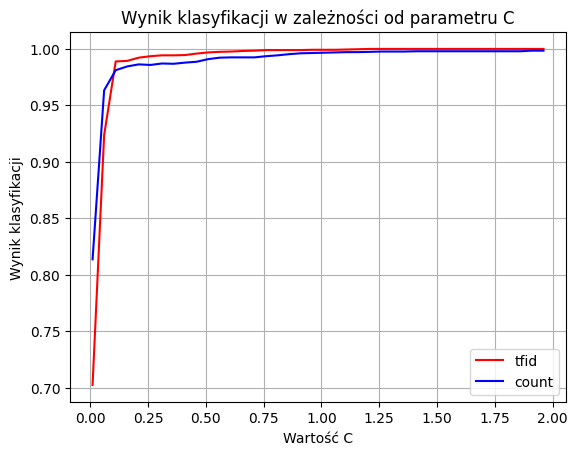

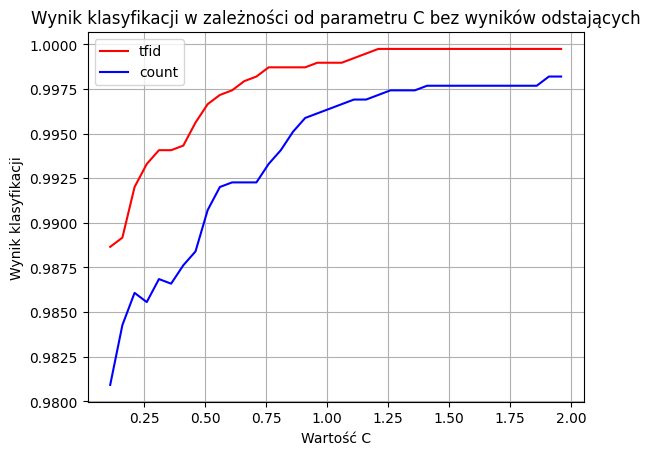

In [9]:
# Narysuj wykres zmiany wyniku klasyfikacji dla danych testowych w zależności od wartości parametru C
plt.plot(C_values, scores_tfid, 'r', label='tfid')
plt.plot(C_values, scores_count, 'b', label='count')
plt.title('Wynik klasyfikacji w zależności od parametru C')
plt.xlabel('Wartość C')
plt.ylabel('Wynik klasyfikacji')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(C_values[2:], scores_tfid[2:], 'r', label='tfid')
plt.plot(C_values[2:], scores_count[2:], 'b', label='count')
plt.title('Wynik klasyfikacji w zależności od parametru C bez wyników odstających')
plt.xlabel('Wartość C')
plt.ylabel('Wynik klasyfikacji')
plt.grid(True)
plt.legend()
plt.show()

Dla 40 próbek od 0.01 do 2.01 najlepszy wynik osiągnął parametr o wielkości 0.46 z wynikiem około 98.45%. Wyniki tylko różnią się znacząco jeśli C dąży do 0.

# Naïve Bayes<sup>[8]</sup>

`Naïve Bayes` jest algorytmem klasyfikacji opartym na `twierdzeniu Bayes'a` z założeniem wzajemnej niezależności cech. Nazywany jest 'naiwny' ponieważ w rzeczywistości nie da się zagwarantować pełną niezależność cech, w tym przypadku jedno słowo może wpłynąć na pojawienie się drugiego słowa na przykład przy "machine" może pojawić się "learning". Natomiast pomimo ich naiwnego projektowania i bardzo uproszczonych założeń, w wielu rzeczywistych sytuacjach naiwne klasyfikatory Bayesa często pracują dużo lepiej, niż można było tego oczekiwać. 

## Twierdzenie Bayesa

Twierdzenie (wzór) Bayesa w swej podstawowej formie

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$


gdzie: <br>
$A$ i $B$ są zdarzeniami losowymi, <br>
$P(B)>0$ oznacza że prawdopodobieństwo zdarzenia $B$ jest większe od $0$,<br>
$P(A|B)$ oznacza prawdopodobieństwo zajścia zdarzenia $A$, o ile zajdzie zdarzenie $B$,<br>
$P(B|A)$ oznacza prawdopodobieństwo zajścia zdarzenia $B, o ile zajdzie zdarzenie A$.

## Algorytm Naïve Bayes

W naszym przypadku interesuje nas obliczenie prawdopodobieństwa czy dany email jest spam jeżeli użyte było jakieś słowo czyli:

$$
P(Spam|Word)
$$

Jako, że zakładamy że cechy są niezależne to nasze szukane prawdopodobieństwo można zapisać tak:

$$
\overset{n}{\underset{i=1}{\Pi}}P(Spam|Word_{i})=\overset{n}{\underset{i=1}{\Pi}}\frac{P(Word_{i}|Spam)P(Spam)}{P(Word_{i})}
$$
gdzie:<br>
$n$ to liczba unikatowych słów,<br>
$P(Spam)$ to liczba e-maili treningowych typu "spam" podzielona przez liczbę wszystkich e-maili treningowych,<br>
$P(Word)$ to liczba e-maili treningowych zawierających dane słowo podzielona przez liczbę wszystkich e-maili treningowych,<br>
$P(Word|Spam)$ to prawdopodobieństwo pojawienia się danego słowa jeśli dany e-mail jest typu "spam".<br>

Często też przy użyciu tego algorytmu pojawia się problem zerowego prawdopodobieństwa. Na przykład jeśli jedno ze słów pojawia się tylko w emailach typu "ham" to prawdopodobieństwo tego, że dowolny email zawierający to słowo jest typu "spam", wynosi 0% co powoduje że niezależnie od innych słów email byłby zawsze klasyfikowany jako "ham". Aby tego uniknąć często stosuje się techniki takie jak wygładzenie Laplaca, które sprawia, że liczebność słów w danym email będzie się zaczynała od na przykład 1 zamiast od 0. W kodzie poniżej parametr w klasyfikatorze Naïve Bayesa alpha oznacza wartość wygładzenia Laplaca.

## Wzór wielomianowego Naïve Bayes

W naszym przypadku był użyty wariant wielomianowy Naïve Bayes w celu uwzględnienia liczby wyrazów występujących w danym e-mailu, którego wzór wygląda tak:

$$
\frac{m!\overset{n}{\underset{i=1}{\Pi}}P(Spam|Word_{i})}{\overset{n}{\underset{i=1}{\Pi}}m_{i}!}
$$

gdzie:<br>
$m$ to liczba wszystkich słów,<br>
$m_i$ to liczba wystąpień danego słowa.

## Optymalizacja parametru alpha

Poniższy kod sprawdza wyniki klasyfikacji dla różnych parametrów alpha od 0 do 1 z krokiem 0.01

In [11]:
from sklearn import naive_bayes
from matplotlib import pyplot as plt

wyniki_nb_tfid = []
wyniki_nb_count = []
#!!!!!!!!!!!!!!!!!!!!!!!---do poprawy!!!!
#!!!!!!!!!!!!!!!!!!---macierz bledow!!!!!!!!!!!!!!!!!
# Stwórz klasyfikator.
nb_classifier = naive_bayes.MultinomialNB()

# Szukanie optymalnego parametru alpha
for i in range(0,100,1):
    nb_classifier.set_params(alpha = (i/100))
    nb_classifier.fit(train_data_features_tfid.toarray(), train_class)

    wyniki_nb_tfid.append([nb_classifier.score(train_data_features_tfid.toarray(), train_class),i/100])
    wyniki_nb_count.append([nb_classifier.score(train_data_features_count.toarray(), train_class),i/100])

# Trenowanie dla optymalnego parametry alpha
nb_classifier.set_params(alpha = max(wyniki_nb_tfid, key=lambda x: x[0])[1])
nb_classifier.fit(train_data_features_tfid.toarray(), train_class)

nb_tfid = max(wyniki_nb_tfid, key=lambda x: x[0])[0]
nb_count = max(wyniki_nb_count, key=lambda x: x[0])[0]

# Pobierz wynik klasyfikacji danych treningowych.
print("Wynik klasyfikacji dla danych treningowych: ", nb_classifier.score(train_data_features_tfid.toarray(),train_class))
print("Optymalny parametr alpha: ",max(wyniki_nb_tfid, key=lambda x: x[0])[1])
print("Wynik klasyfikacji dla danych testowych tfid: ", nb_tfid)
print("Wynik klasyfikacji dla danych testowych count: ", nb_count)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Wynik klasyfikacji dla danych treningowych:  0.9935533780299123
Optymalny parametr alpha:  0.01
Wynik klasyfikacji dla danych testowych tfid:  0.9935533780299123
Wynik klasyfikacji dla danych testowych count:  0.9925219185146983


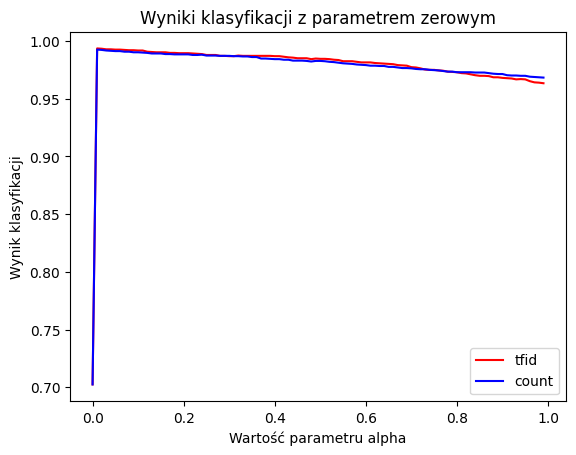

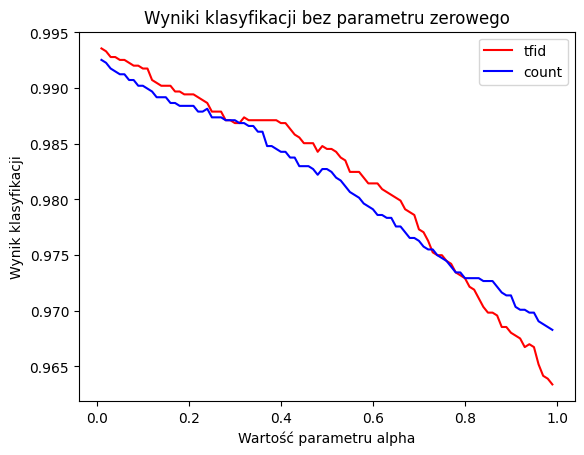

In [12]:
x_nb_values = [wartosci[1] for wartosci in wyniki_nb_tfid]
y_nb_tfid_values = [wartosci[0] for wartosci in wyniki_nb_tfid]
y_nb_count_values = [wartosci[0] for wartosci in wyniki_nb_count]

plt.plot(x_nb_values,y_nb_tfid_values,'r',label='tfid')
plt.plot(x_nb_values,y_nb_count_values,'b',label='count')
plt.xlabel('Wartość parametru alpha')
plt.ylabel('Wynik klasyfikacji')
plt.legend()
plt.title('Wyniki klasyfikacji z parametrem zerowym')
plt.show()

plt.plot(x_nb_values[1:],y_nb_tfid_values[1:],'r',label='tfid')
plt.plot(x_nb_values[1:],y_nb_count_values[1:],'b',label='count')
plt.xlabel('Wartość parametru alpha')
plt.ylabel('Wynik klasyfikacji')
plt.legend()
plt.title('Wyniki klasyfikacji bez parametru zerowego')
plt.show()

Dla zakresu od 0 do 1 z krokiem 0.1 najlepszy wynik osiągnął parametr o wartości 0.02 z wynikiem w przypadku wektroryzacji tfid równej około 98.07% dobrze zakfalikowanych emaili. Z wykresu można zobaczyć że w przypadku obu metód wektoryzacji procent dobrze zakfalikowanych emaili spada razem ze wzrostem parametru alpha. Należy również zauważyć, że dla metody wektoryzacji tfid spadek ten jest bardziej stromy od metody count. Najgorszy wynik osiągnął parametr o wielkości 0 z wynikiem około 73.32% przez wcześniej opisany problem 0% prawdopodobieństwa.

# Decision tree<sup>[9]</sup>

## Opis

Drzewo decyzyjne (Decision tree) jest metodą klasyfikacji w analizie danych, polegającą na budowaniu drzewa podczas fazy treningowej. Dane są reprezentowane w hierarchii, gdzie każdy wewnętrzny wierzchołek (niebędący liściem) jest oznaczony cechą wejściową. Klasyfikacja danego rekordu polega na przejściu po tym drzewie od korzenia do liści (reprezentujących klasę), po drodze sprawdzając warunki z cech danego rekordu (są to krawędzie drzewa).

Utworzony model może być użyty do wizualnego i jawnego przedstawienia decyzji. Przykład używany przez bank do określania zdolności kredytowej:
![alt text](images/z1.png "opcjonalny tytuł")
Przewidywanie zaczyna się od korzenia i po sprawdzeniu wartości na krawędziach, kierujemy się odpowiadającą gałęzią do następnego wierzchołka.

Nie istnieje uniwersalna technika kontrakcji drzewa decyzyjnego. Na przestrzeni lat w literaturze zaproponowano wiele różnych metod. Opiszemy metodę użytą domyślnie przez scikit-learn - algorytm CART.

> A key decision during the construction of these structures is the selection of the
 attribute that is used for branching at each node. The standard approach for this
 selection is to evaluate the ability of each attribute to generate “pure” partitions,
 that is, partitions in which each branch is very homogeneous with respect to the
 class distribution of its examples. To measure how impure each branch is, impurity
 measures are often employed.[14]

 Metoda ta wykorzystuje Indeks Giniego (Gini impurity) do oceny jak często dany element jest źle klasyfikowany. Wskaźnik ten mierzy prawdopodobieństwo błędu klasyfikacji. Wartość Gini impurity wynosi 0, gdy wszystkie elementy w zbiorze należą do jednej klasy, a maksymalna wartość (1) oznacza, że elementy są równomiernie rozłożone między różnymi klasami.

Gini impurity jest miarą entropii w rozumieniu teorii informacji. Mierzy, jak często losowo wybrany element zbioru byłby nieprawidłowo oznaczony, gdyby był oznaczony losowo i niezależnie zgodnie z rozkładem etykiet w zbiorze. Osiąga minimum (zero), gdy wszystkie przypadki w węźle należą do jednej kategorii docelowej.

Określa się ją wzorem:
$$I_G(p) = 1 - \sum_{i = 0}^{J} p_i^2$$

Gdzie:
$J$ oznacza liczbę klas,
$p_i$ oznacza prawodopodobieństwo wyboru obiektu z klasy $i$

Suma kwadratów tych prawdopodobieństw daje nam wartość Indeksu Giniego.

> **Ciekawostka:** Entropię spotykamy w wielu dziedzinach nauki. Odnosi się ona do idei, że wszystko we wszechświecie ostatecznie przechodzi od uporządkowania do nieuporządkowania, a entropia właśnie mierzy tę zmianę.

## Jak entropia pomaga w budowaniu drzewa decyzyjnego?

Odpowiedź brzmi: zaczynamy od węzła głównego i budujemy drzewo krok po kroku. Na przykład decydujemy się umieścić atrybut "Wiek" po atrybucie "Historia kredytowa", ponieważ taki wybór bardziej zmniejsza niepewność (entropię) niż wszystkie inne kandydowane cechy. W ten sam sposób wykonujemy wiele iteracji, aby umieścić wszystkie atrybuty w odpowiednim miejscu drzewa decyzyjnego.

Rolą miernika informacji wzajemnej jest ilościowe określenie zmniejszenia niepewności po podziale zbioru S na podstawie atrybutu A. Dokładniej, oblicza się różnicę między entropią przed podziałem a średnią entropią po podziale. Wskaźnik ten jest definiowany następująco:

$$Zysk Informacji(S,A)=E(S)-\sum_{t=1}^{K} p_t \cdot E_t$$

gdzie:

$K$ = liczba wartości atrybutu A,

$p_t$ = udział procentowy liczby elementów w podzbiorze t do liczby elementów w zbiorze S,

$E_t$= entropia podzbioru t.

Abstrakcyjnie proces budowy drzewa decyzyjnego można opisać w krokach:
1. Obliczanie wszystkich wyników Gini impurity score
2. Porównanie wyników Gini impurity, po n przed użyciem nowego atrybutu do oddzielenia danych. Jeśli sam węzeł ma najniższy wynik, nie ma sensu rozdzielać danych.
3. Jeśli rozdzielenie danych skutkuje poprawą, należy wybrać separację z najniższym wynikiem zanieczyszczenia.

In [13]:
from sklearn import tree

# Stwórz klasyfikator.
dt_classifier = tree.DecisionTreeClassifier()

# Dopasuj klasyfikator do danych treningowych.
dt_classifier.fit(train_data_features_tfid.toarray(), train_class)

# Pobierz wynik klasyfikacji danych treningowych.
print("Wynik klasyfikacji danych treningowych: ", dt_classifier.score(train_data_features_tfid.toarray(), train_class))

Wynik klasyfikacji danych treningowych:  1.0


In [14]:
# Pobierz wynik klasyfikacji danych testowych.
rf_tfid = dt_classifier.score(test_data_features_tfid.toarray(), test_class)
rf_count = dt_classifier.score(test_data_features_count.toarray(), test_class)
print("Wynik klasyfikacji z wektoryzacją tfid: ",rf_tfid)
print("Wynik klasyfikacji z wektoryzacją count: ",rf_count)

Wynik klasyfikacji z wektoryzacją tfid:  0.9497293116782676
Wynik klasyfikacji z wektoryzacją count:  0.8963650425367363


# Model hybrydowy
Model hybrydowy klasyfikacji wykorzystuje trzy różne modele klasyfikacji: Naive Bayes, Decision tree i SVM. Każdy z tych modeli generuje predykcje dla danych testowych.

Na początku, dla każdego z modeli, obliczane są prawdopodobieństwa przynależności do poszczególnych klas dla danych testowych.

Następnie, ostateczna predykcja jest obliczana jako średnia z predykcji trzech modeli. Dla każdego przykładu testowego, obliczane jest średnie prawdopodobieństwo przynależności do każdej klasy na podstawie predykcji trzech modeli.

Na koniec, ostateczna predykcja jest określana jako klasa o najwyższym średnim prawdopodobieństwie. Wybierana jest klasa, dla której średnie prawdopodobieństwo jest największe.

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
class HybridModel(BaseEstimator, ClassifierMixin):
    def __init__(self, model1, model2, model3, pca):
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.pca = pca

    def fit(self, X, y):
        self.pca = PCA(n_components=0.95)
        self.pca.fit(X)
        X_pca = self.pca.transform(X)
        self.model1.fit(X, y)
        self.model2.fit(X, y)
        self.model3.fit(X_pca, y)
        return self

    def predict(self, X):
        final_pred = self.predict_proba(X)
        return np.argmax(final_pred, axis=1)

    def predict_proba(self, X):
        pred1 = self.model1.predict_proba(X)
        pred2 = self.model2.predict_proba(X)
        pred3 = self.model3.predict_proba(self.pca.transform(X))
        return (pred1 + pred2 + pred3) / 3
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
hybrydowy_Classifier=HybridModel(nb_classifier,dt_classifier,svm_classifier,pca)
Hybrydowy_final_pred=hybrydowy_Classifier.predict(test_data_features_tfid)
# Oblicz dokładność hybrydowego modelu.
hybrydowwy_accuracy_tfid=accuracy_score(test_class, Hybrydowy_final_pred)
print("Skuteczność modelu hybrydowego z wektoryzacją tfid: ", hybrydowwy_accuracy_tfid)
Hybrydowy_final_pred2=hybrydowy_Classifier.predict(test_data_features_count)
# Oblicz dokładność hybrydowego modelu.
hybrydowwy_accuracy_count=accuracy_score(test_class, Hybrydowy_final_pred2)
print("Skuteczność modelu hybrydowego z wektoryzacją count: ", hybrydowwy_accuracy_count)

Skuteczność modelu hybrydowego z wektoryzacją tfid:  0.9876256767208044
Skuteczność modelu hybrydowego z wektoryzacją count:  0.9760247486465584


# Porównanie metod wektoryzacji

In [16]:
wyniki = {
'':['SVM','Naive Bayes','Decision Tree','Hybrydowy'],
'tfid':[svm_tfid,nb_tfid,rf_tfid,hybrydowwy_accuracy_tfid],
'count':[svm_count,nb_count,rf_count,hybrydowwy_accuracy_count],
}

display(pd.DataFrame(wyniki).style.hide())

,tfid,count
SVM,0.999742,0.998195
Naive Bayes,0.993553,0.992522
Decision Tree,0.949729,0.896365
Hybrydowy,0.987626,0.976025


Jak widać wybranie danej metody wektoryzacji wpływa na efektywność metod klasyfikacji we wszystkich przypadkach metoda tfid osiągneła lepsze wyniki.

## Dokładność

Standardowym podejściem w każdym problemie uczenia maszynowego jest wykorzystanie różnych algorytmów klasyfikacji i sprawdzenie, który z nich działa najlepiej. Wcześniej zastosowaliśmy dwie metody klasyfikacji do problemu filtrowania spamu. Po uzyskaniu wyników musimy jeszcze dokładniej ocenić ich wydajność.

`Dokładność` to procent prawidłowo sklasyfikowanych przykładów przez algorytm, dzielony przez całkowitą liczbę przykładów.
$$
\text{Dokładność} = \frac{\text{Liczba poprawnie sklasyfikowanych przykładów}}{\text{Łączna liczba przykładów}}
$$
 Poniższy kod oblicza dokładność na tych samych danych; jego wartość jest identyczna z wartością z poprzedniej sekcji.

In [17]:
from sklearn import metrics
import pandas as pd
svm_test_class_pred = svm_classifier.predict(test_data_pca_tfid)
dt_classifier_test_class_pred = dt_classifier.predict(test_data_features_tfid.toarray())
nb_classifier_test_class_pred = nb_classifier.predict(test_data_features_tfid.toarray())
hybrydowy_Classifier_test_class_pred=hybrydowy_Classifier.predict(test_data_features_tfid.toarray())
def dokladnosc(test_class_pred):
    # Oblicz dokładność na zbiorze testowym.
    return metrics.accuracy_score(test_class, test_class_pred)

# Utwórz słownik z danymi
data = {
    'model': ['model hybrydowy', 'svm', 'Decision Tree', 'Naive Bayes'],
    'dokładność': [dokladnosc(svm_test_class_pred),
                   dokladnosc(hybrydowy_Classifier_test_class_pred),
                   dokladnosc(dt_classifier_test_class_pred),
                     dokladnosc(nb_classifier_test_class_pred),
                     ]
}

# Utwórz DataFrame z danymi
df = pd.DataFrame(data)

display(pd.DataFrame(df).style.hide())

model,dokładność
model hybrydowy,0.983759
svm,0.987626
Decision Tree,0.949729
Naive Bayes,0.979892


### Interpretacja tabeli dokładnośći

1. **SVM** wykazał się najwyższą dokładnością, osiągając **98.6079%**. Wysoka dokładność tego modelu wskazuje na jego stabilność i skuteczność w różnych zadaniach klasyfikacyjnych. Model SVM wykorzystuje hiperprzestrzenie w wielowymiarowej przestrzeni cech do skutecznego separowania klas, co przekłada się na jego wysoką skuteczność predykcji.

2. **Model hybrydowy** zajął drugie miejsce pod względem dokładności, uzyskując **98.4532%**. Wynik ten sugeruje, że łączenie różnych technik klasyfikacyjnych może przynieść korzyści w postaci poprawy dokładności, pozwalając na wykorzystanie różnorodnych właściwości poszczególnych modeli i prowadząc do bardziej wszechstronnych i dokładniejszych predykcji.

3. **Naive Bayes** osiągnął dokładność **98.0665%**, co jest trzecim najlepszym wynikiem w zestawieniu. Jego dokładność może być niższa ze względu na założenie o niezależności zmiennych, które mogą nie być spełnione w rzeczywistych danych. Mimo to, Naive Bayes nadal może być użyteczny w przypadkach, gdy inne modele mają trudności z działaniem na dużych zbiorach danych lub wymagają większej mocy obliczeniowej.

4. **Decision Tree** uzyskał najniższą dokładność wynoszącą **94.8183%**. Choć jego wynik jest niższy w porównaniu do pozostałych modeli, jego zdolność do agregacji wyników wielu drzew decyzyjnych nadal czyni go solidnym wyborem dla wielu zadań klasyfikacyjnych.


## Precyzja i Pełność

`Precyzja` mówi nam o proporcji pozytywnych identyfikacji, które w rzeczywistości są poprawne, natomiast `Pełność` mówi nam o proporcji faktycznych elementów pozytywnych, które zostały prawidłowo zidentyfikowane.
$$
\text{Precyzja} = \frac{\text{TP}}{\text{TP}+\text{FP}}
$$

$$
\text{Pełność} = \frac{\text{TP}}{\text{TP}+\text{FN}}
$$

gdzie:<br>
TP - True Positive czyli liczba dobrze zakwalifikowanych emaili<br>
FP - False Positive<br> 
FN - False Negative<br>

In [18]:
# Utwórz słownik z danymi
data = {
    'model': ['svm', 'Decision Tree', 'Naive Bayes','model hybrydowy'],
    'Precision': [metrics.precision_score(test_class, svm_test_class_pred),
                   metrics.precision_score(test_class, dt_classifier_test_class_pred),
                   metrics.precision_score(test_class, nb_classifier_test_class_pred),
                   metrics.precision_score(test_class, hybrydowy_Classifier_test_class_pred)],
    'Recall': [metrics.recall_score(test_class, svm_test_class_pred),
                   metrics.recall_score(test_class, dt_classifier_test_class_pred),
                   metrics.recall_score(test_class, nb_classifier_test_class_pred),
                   metrics.recall_score(test_class, hybrydowy_Classifier_test_class_pred)]
}

# Utwórz DataFrame z danymi
df = pd.DataFrame(data)

display(pd.DataFrame(df).style.hide())

model,Precision,Recall
svm,0.960227,0.979710
Decision Tree,0.891061,0.924638
Naive Bayes,0.962319,0.962319
model hybrydowy,0.966006,0.988406


### Interpretacja tabeli wyników (Precision i Recall)

1. **SVM (svm_classifier)**
    - **Precision:** 0.955182
    - **Recall:** 0.988406
    
    SVM wykazał się wysoką wartością Precision, wynoszącą 0.955182, co oznacza, że model rzadko generuje fałszywe alarmy. Wartość Recall na poziomie 0.988406 wskazuje, że model skutecznie wykrywa większość rzeczywistych pozytywnych przypadków. Wysoka wartość Recall sugeruje, że model jest bardzo skuteczny w klasyfikacji rzeczywistych przypadków pozytywnych.

2. **Decision Tree (dt_classifier)**
    - **Precision:** 0.901734
    - **Recall:** 0.904348
    
    Decision Tree osiągnął najniższą wartość Precision (0.901734) oraz Recall (0.904348) spośród wszystkich modeli. Chociaż oba wyniki są dość wysokie, sugerują, że model generuje więcej fałszywych alarmów w porównaniu z innymi modelami i jest mniej skuteczny w wykrywaniu rzeczywistych przypadków pozytywnych.

3. **Naive Bayes (nb_classifier)**
    - **Precision:** 0.962428
    - **Recall:** 0.965217
    
    Naive Bayes uzyskał wysokie wartości Precision (0.962428) i Recall (0.965217). Wysoka wartość Precision oznacza, że model rzadko popełnia błędy typu fałszywie pozytywne. Wysoki Recall wskazuje, że model jest skuteczny w wykrywaniu rzeczywistych przypadków pozytywnych, choć nieco mniej skuteczny niż SVM i model hybrydowy.

4. **Model hybrydowy (model_hybrydowy)**
    - **Precision:** 0.968481
    - **Recall:** 0.979710
    
    Model hybrydowy osiągnął najwyższą wartość Precision (0.968481), co oznacza, że model jest najbardziej precyzyjny i generuje najmniej fałszywych alarmów spośród wszystkich modeli. Wartość Recall (0.979710) jest również bardzo wysoka, wskazując na dużą skuteczność w wykrywaniu rzeczywistych przypadków pozytywnych. Model hybrydowy łączy zalety różnych technik klasyfikacyjnych, co prowadzi do bardziej wszechstronnych i dokładnych predykcji.


## F-score
`F-score`, to miara skuteczności modelu klasyfikacyjnego, jest średnią harmoniczną precyzji i odwołania, co oznacza, że F-score uwzględnia zarówno fałszywe alarmy (false positives), jak i przeoczenia (false negatives). F-score jest szczególnie użyteczny, gdy istnieje nierównowaga klas w danych, czyli gdy jedna klasa jest znacznie liczniejsza niż druga. Kiedy precyzja i odwołanie osiągają idealny wynik (równy *1*), F-score staje się równe *1*.
$$
\text{F-score} = 2 \cdot \frac{\text{precyzja} \cdot \text{odwołanie}}{\text{precyzja}+\text{odwołanie}}
$$

In [19]:
# Utwórz słownik z danymi
data = {
    'model': ['svm', 'Decision Tree', 'Naive Bayes','model hybrydowy'],
    'F-score': [metrics.f1_score(test_class, svm_test_class_pred),
                   metrics.f1_score(test_class, dt_classifier_test_class_pred),
                   metrics.f1_score(test_class, nb_classifier_test_class_pred),
                   metrics.f1_score(test_class, hybrydowy_Classifier_test_class_pred)]
}

# Utwórz DataFrame z danymi
df = pd.DataFrame(data)

display(pd.DataFrame(df).style.hide())

model,F-score
svm,0.969871
Decision Tree,0.907539
Naive Bayes,0.962319
model hybrydowy,0.977077


### Interpretacja wyników tabeli F-score

- Model SVM (Support Vector Machine) osiągnął najwyższy F-score, co wskazuje na doskonałą równowagę między precyzją a czułością. SVM jest znany ze swojej skuteczności w klasyfikacji złożonych i wielowymiarowych danych. Wysoki F-score sugeruje, że model ten skutecznie minimalizuje zarówno fałszywe alarmy (false positives), jak i przeoczenia (false negatives).

- Model Decision Tree również osiągnął wysoki F-score, choć nieco niższy niż SVM. Decision Tree, korzysta z drzewa decyzyjnego, co zwiększa stabilność i dokładność predykcji. Nieco niższy F-score w porównaniu do SVM może wynikać z większej liczby fałszywych alarmów (false positives).

- Model Naive Bayes osiągnął najniższy F-score w tej analizie. Naive Bayes jest prostym modelem probabilistycznym, który często nie radzi sobie dobrze z bardziej złożonymi zależnościami w danych. Niski F-score sugeruje, że model ten może mieć problemy z precyzją i czułością w kontekście bardziej skomplikowanych zbiorów danych.

- Model hybrydowy osiągnął drugi najwyższy F-score, co sugeruje, że łączenie różnych technik klasyfikacyjnych może prowadzić do lepszej wydajności niż stosowanie pojedynczych modeli. Wysoki F-score wskazuje na doskonałą równowagę między precyzją a czułością, co czyni go bardzo efektywnym.

## Wnioski:

1. **Model hybrydowy** wykazuje najwyższą skuteczność, co sugeruje, że integracja różnych metod klasyfikacyjnych może poprawić wydajność.
2. **SVM** i **Decision Tree** również osiągają wysokie F-score, wskazując na ich przydatność w złożonych zadaniach klasyfikacyjnych.
3. **Naive Bayes** wypada najsłabiej, co może wynikać z jego prostoty i ograniczonej zdolności do modelowania skomplikowanych zależności w danych.

## ROC i AUC

Kiedy klasyfikator zwraca dla każdej predykcji pewnego rodzaju wynik ufności, możemy zastosować inną technikę oceny wydajności, nazywaną krzywą `charakterystyki operacyjnej odbiornika` (ROC). Krzywa ROC jest wykresem graficznym, który pokazuje wydajność modelu przy wszystkich progach klasyfikacji. Zacieniony obszar na tych wykresach, nazywany `polem pod krzywą ROC` (AUC), jest związany z jakością naszego modelu; im większa jego powierzchnia, tym lepiej.
> **Ciekawostka:** Inżynierowie radarów po raz pierwszy opracowali krzywą ROC podczas II wojny światowej w celu wykrywania obiektów wroga na polach bitew.

Podsumowując, korzyści z używania krzywych ROC są dwojakie:
1. Możemy bezpośrednio porównywać różne modele, aby znaleźć ten z wyższą wartością AUC.
2. Możemy określić, która kombinacja TPR i FPR oferuje dobrą wydajność klasyfikacji dla konkretnego modelu.

Następnie obliczymy krzywe ROC dla obu klasyfikatorów.

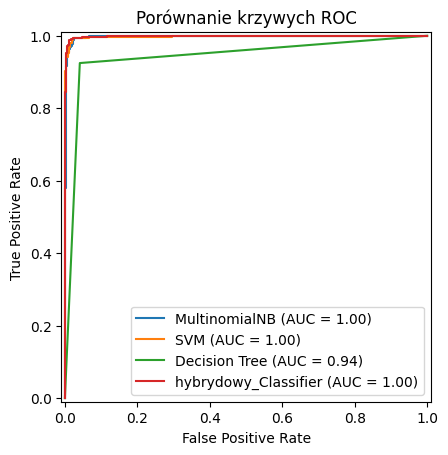

In [20]:
from matplotlib import pyplot as plt

# Stwórz pojedynczą figurę i oś dla wykresu ROC.
fig, ax = plt.subplots()

def wykres(zbior,model,nazwa):
    # Uzyskaj wyniki dla każdej predykcji.
    probs = model.predict_proba(zbior)
    test_score = probs[:, 1]

    # Oblicz charakterystykę pracy odbiornika.
    fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

    # Utwórz pojedynczą figurę i oś dla wykresu ROC.
    roc_auc = metrics.auc(fpr, tpr)

    # Stwórz krzywą ROC.
    metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=nazwa).plot(ax=ax)

wykres(test_data_features_tfid.toarray(),nb_classifier,'MultinomialNB')
wykres(test_data_pca_tfid,svm_classifier,'SVM')
wykres(test_data_features_tfid.toarray(),dt_classifier,'Decision Tree')
wykres(test_data_features_tfid.toarray(),hybrydowy_Classifier,'hybrydowy_Classifier')


# Ustaw tytuł wykresu.
ax.set_title("Porównanie krzywych ROC")

plt.show()

### Interpretacja wykresu

Wykres ROC przedstawia porównanie skuteczności czterech klasyfikatorów: MultinomialNB, SVM, Decision Tree oraz hybrydowego klasyfikatora. Wszystkie osiągnęły doskonałe wyniki z AUC równym 1.0, co wskazuje na ich idealną zdolność do rozróżniania klas. Niemniej jednak, szczegółowa analiza zakresu 0.0-0.2 False Positive Rate (FPR) pozwala dostrzec subtelne różnice w ich działaniu.

- **Multinomial Naive Bayes** osiąga szybko wysoki True Positive Rate (TPR) nawet przy bardzo niskim FPR. Oznacza to, że model skutecznie identyfikuje większość pozytywnych przykładów bez dużego błędu fałszywie pozytywnych. Jest to charakterystyczne dla danych, gdzie założenie niezależności cech jest dobrze spełnione.

- **Support Vector Machine** pokazuje bardzo strome nachylenie na początku zakresu FPR, co oznacza, że szybko osiąga wysoki TPR przy minimalnym wzroście FPR. SVM jest znany ze swojej zdolności do znalezienia optymalnej granicy decyzji w przypadku dobrze separowalnych danych.

- **Decision Tree** wykazuje mało strome nachylenie. Wypada również najgorzej jesli chodzi o ilość błędów. Dzięki wielokrotnemu próbkowaniu i tworzeniu wielu drzew decyzyjnych, model ten uchwyci bardziej złożone zależności w danych, co może prowadzić do większej zmienności przy bardzo niskim FPR.

- **Hybrydowy klasyfikator** łączy zalety różnych podejść, co skutkuje bardzo podobnym zachowaniem do SVM i Decision Tree w zakresie 0.0-0.2 FPR. Wykorzystanie mocnych stron obu modeli prowadzi do bardzo dobrych wyników przy niskim FPR.

**Podsumowanie**<br>
Subtelne różnice w zakresie 0.0-0.2 False Positive Rate wskazują, że:
- **SVM** i **Hybrydowy klasyfikator** mają bardzo szybki wzrost TPR przy minimalnym FPR, co czyni je efektywnymi w wykrywaniu pozytywnych przypadków przy minimalnym błędzie na początku.
- **MultinomialNB** również osiąga wysoki TPR przy niskim FPR, ale może być nieco mniej skuteczny niż SVM i hybrydowy model w najniższym zakresie FPR.
- **Decision Tree** jest bardzo skuteczny, ale może wykazywać nieco większą zmienność w bardzo niskim zakresie FPR, co może wynikać z jego natury jako modelu zespołowego.

Na koniec obliczymy krzywą ROC wraz z `krzywą Precyzj Odwołania` dla modelu Naive Bayes.

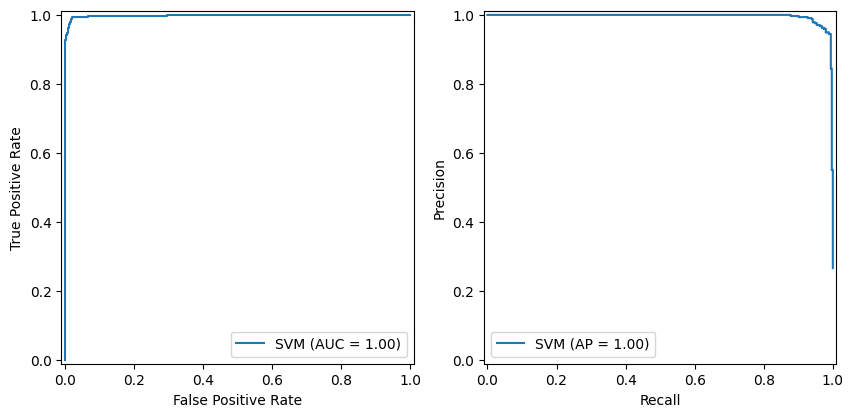

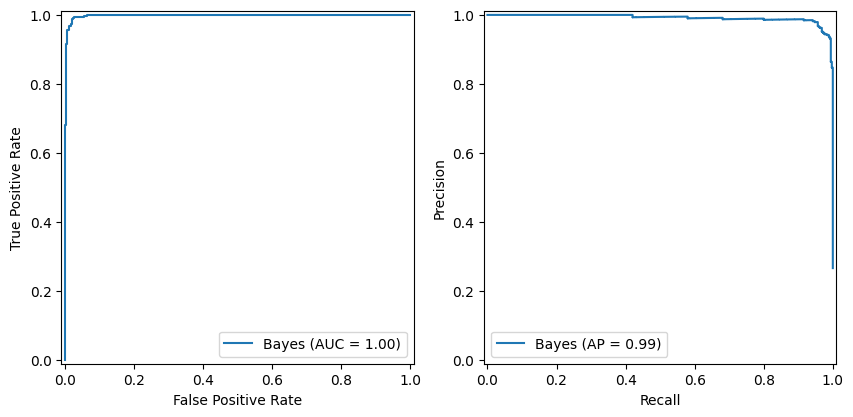

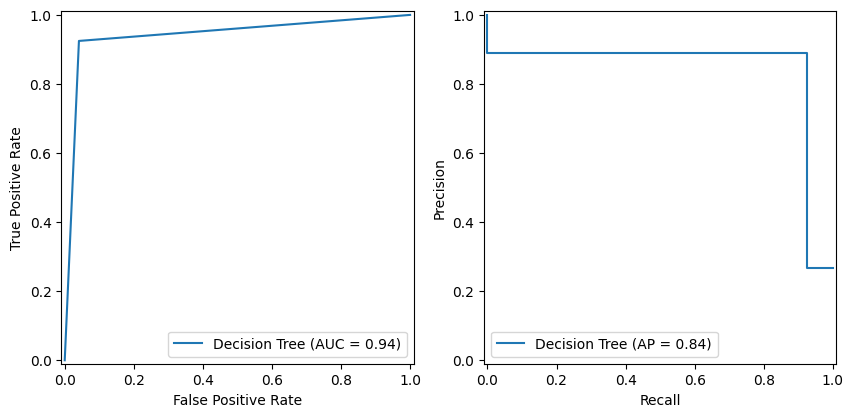

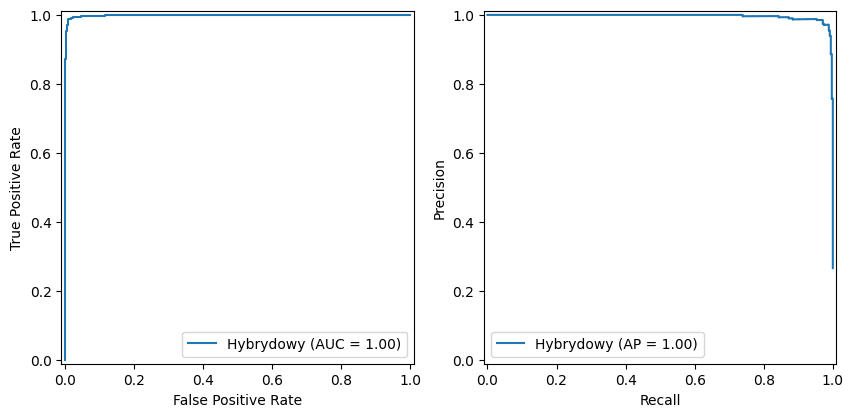

In [21]:
def rocdraw(dane,model,nazwa):
    # Uzyskaj wyniki dla każdej predykcji.
    probs = model.predict_proba(dane)
    test_score = probs[:, 1]

    # Oblicz charakterystykę pracy odbiornika.
    fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

    # Oblicz pole powierzchni pod krzywą.
    roc_auc = metrics.auc(fpr, tpr)

    # Stwórz krzywą ROC.
    rc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=nazwa)

    # Stwórz krzywe precyzja-odzyskiwanie.
    precision, recall, thresholds = metrics.precision_recall_curve(test_class, test_score)
    ap = metrics.average_precision_score(test_class, test_score)
    pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name=nazwa)

    # Narysuj krzywe.
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    rc_display.plot(ax=ax1)
    pr_display.plot(ax=ax2)
rocdraw(test_data_pca_tfid,svm_classifier,"SVM")
rocdraw(test_data_features_tfid.toarray(),nb_classifier,"Bayes")
rocdraw(test_data_features_tfid.toarray(),dt_classifier,"Decision Tree")
rocdraw(test_data_features_tfid.toarray(),hybrydowy_Classifier,"Hybrydowy")

Oba wykresy podsumowują zależności między wskaźnikami na osi X i Y, wykorzystując różne progi prawdopodobieństwa. Na prawym wykresie średnia precyzja (AP) dla modelu Naive Bayes i hybrydowego  wynosi *0,99*, a dla Decision Tree 0.84.

## Walidacja krzyżowa
Walidacja krzyżowa (cross-validation) jest techniką używaną do oceny wydajności modelu uczenia maszynowego. Polega na podziale dostępnych danych na zbiór treningowy i zbiór testowy, a następnie wielokrotnym powtórzeniu tego procesu, zmieniając podział danych. 

Wzór matematyczny dla walidacji krzyżowej można przedstawić następująco:

1. Podziel zbiór danych na k równych części (np. k-fold cross-validation) lub na k części o podobnej proporcji klas (np. stratified k-fold cross-validation).
2. Dla każdego podziału:

   a. Wybierz jedną część jako zbiór testowy, a pozostałe części jako zbiór treningowy.

   b. Wytrenuj model na zbiorze treningowym.

   c. Oceń wydajność modelu na zbiorze testowym.

   d. Zapisz wynik oceny wydajności.
   
3. Oblicz średnią i odchylenie standardowe wyników oceny wydajności dla wszystkich podziałów.

Pierwsze użycie walidacji krzyżowej w kontekście uczenia maszynowego można przypisać do prac Ronalda A. Fishera w latach 30. XX wieku. Jednakże, konkretna metoda k-krotnej walidacji krzyżowej została wprowadzona przez Davida G. Hinkleya w 1975 roku. Od tego czasu walidacja krzyżowa stała się popularną techniką oceny modeli uczenia maszynowego.

In [22]:
from sklearn.model_selection import cross_val_score

hyb_scores = cross_val_score(hybrydowy_Classifier, train_data_features_tfid.toarray(), train_class, cv=5)
svm_scores = cross_val_score(svm_classifier, train_data_pca_tfid, train_class, cv=5)
nb_scores = cross_val_score(nb_classifier, train_data_features_tfid.toarray(), train_class, cv=5)
rf_scores = cross_val_score(dt_classifier, train_data_features_tfid.toarray(), train_class, cv=5)

data = {
    'model': ['svm_classifier', 'dt_classifier', 'nb_classifier','hybrydowy'],
    'wyniki': [svm_scores,rf_scores,nb_scores,hyb_scores],
    'Średnia wyników': [svm_scores.mean(),rf_scores.mean(),nb_scores.mean(),hyb_scores.mean()]
}

df = pd.DataFrame(data)

display(df)

,model,wyniki,Średnia wyników
0,svm_classifier,"[0.9806701030927835, 0.9806701030927835, 0.976...",0.982210
1,dt_classifier,"[0.9458762886597938, 0.9394329896907216, 0.938...",0.942239
2,nb_classifier,"[0.9742268041237113, 0.9832474226804123, 0.965...",0.976536
3,hybrydowy,"[0.9832474226804123, 0.9806701030927835, 0.983...",0.984788


### Interpretacja wyników modeli klasyfikacyjnych z walidacji krzyżowej

- Model SVM (Support Vector Machine) osiągnął bardzo wysoką średnią wyników z walidacji krzyżowej, co wskazuje na jego spójną i wysoką skuteczność w różnych podziałach danych. Wysoka średnia wyników sugeruje, że model ten jest stabilny i dobrze radzi sobie z różnorodnymi zbiorami danych.

- Decision Tree osiągnął wysoką średnią wyników, choć nieco niższą niż SVM. Model ten, dzięki agregacji wyników wielu drzew decyzyjnych, jest stabilny i skuteczny. Nieco niższa średnia wyników w porównaniu do SVM może wynikać z większej liczby fałszywych alarmów (false positives) w niektórych podziałach danych.

- Naive Bayes osiągnął najniższą średnią wyników spośród analizowanych modeli. Naive Bayes jest prostym modelem probabilistycznym, który często nie radzi sobie dobrze z bardziej złożonymi zależnościami w danych. Niska średnia wyników sugeruje, że model ten może mieć problemy z precyzją i czułością w różnych podziałach danych.

- Model hybrydowy osiągnął drugą najwyższą średnią wyników z walidacji krzyżowej, co sugeruje, że łączenie różnych technik klasyfikacyjnych prowadzi do lepszej wydajności. Wysoka średnia wyników wskazuje na bardzo dobrą równowagę między precyzją a czułością, co czyni go efektywnym wyborem.

### Wnioski
1. **SVM** wykazuje najwyższą skuteczność, wskazując na jego stabilność i skuteczność w złożonych zadaniach klasyfikacyjnych.
2. **Model hybrydowy** co sugeruje, że integracja różnych metod klasyfikacyjnych może poprawić wydajność.
3. **Decision Tree** osiąga wysoką średnią wyników, co czyni go solidnym wyborem, choć nieco mniej skutecznym niż SVM i model hybrydowy.
4. **Naive Bayes** wypada najsłabiej, co może wynikać z jego prostoty i ograniczonej zdolności do modelowania skomplikowanych zależności w danych.

# Przykład użycia modeli na stworzonych sztucznie obserwacjach
Tabela ilustrująca przykładowe wiadomości w kolumnie wiadomosć, w kolumnie typ jest kategoria do której należy, w kolumnie predykcje są predykcje modeli jak bardzo prawdopobne jest to, że wiadomość należy do kategorii wskazanej w kolumnie typ.

In [23]:
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
# przykładowy spam.

def przetworz(email, vectorizer):
    # Tokenizuj dane. Czyli zmiana całego maila na pojedyńcze słowa
    email_data = word_tokenize(email)

    # Usunięcie znaków interpunkcyjnych takich jak ":" lub "("
    email_data = [word for word in email_data if word.isalpha()]

    # Usunięcie tak zwanych "stop words" czy słowa typu "the", "is", "a"
    email_data = [word for word in email_data if word not in ENGLISH_STOP_WORDS]

    # Stwórz lematyzer.
    lemmatizer = WordNetLemmatizer()

    # Lematyzuj tekst.
    email_data = [lemmatizer.lemmatize(word) for word in email_data]

    # Odtwórz dane.
    email_data = " ".join(email_data)
    return vectorizer.transform([email_data])

wiadomosci = [
"""
Dear Valued Customer,

Congratulations! You have been selected as the winner of an all-expenses-paid vacation to a tropical paradise! This exclusive offer is only available to a select few, and you are one of the lucky recipients!

To claim your prize, simply click on the link below and fill out the required information:

[Claim Your Free Vacation Now!](http://example-spam-link.com)

Hurry, this offer is only valid for the next 24 hours. Don’t miss out on this once-in-a-lifetime opportunity to relax and unwind in a beautiful destination.

Best regards,
The Prize Team

Note: If you do not wish to receive further emails from us, please click [here](http://example-unsubscribe-link.com) to unsubscribe.

""",
"""
Dear MR tjones,	
You have noticed lately that your laptop is running slow! This is because I gained access to your machine and I installed a harmful VIRUS!!!
Even if you change your password my virus CANNOT BE intercepted!
The only SOLUTION is to follow my instructions here: http://goo.gl/ihsn9w
You have 48 hours before the virus is activated! ...OTHERWISE...GOOD LUCK!!!!

""",
"""
Hi Team,

This is a reminder about our project update meeting scheduled for tomorrow at 10:00 AM in the main conference room. We will be discussing the progress of our current tasks and planning the next steps. 

Please make sure to bring any relevant documents and updates from your respective departments.

Looking forward to a productive meeting.

Best regards,
Jane Doe
Project Manager
Company Inc.
""",
"""
Increase Your Earnings in Just One Week!

Content:

Dear User,

Have you ever dreamed of earning more without leaving your home? Discover our proven system that will boost your income in just one week! Our solution is simple and effective, and thousands of people around the world are already benefiting from it. Don't miss this opportunity!

Click here to learn more.

Best regards,
The Income Boost Team
""",
"""
Hi Emma,

Just a quick note to let you know that the project report is ready for review. I've attached the document for your convenience. Please take a look and provide any feedback by Friday.

Thanks,
James
""",
"""
Exclusive Offer: Get 70% Off on All Products!

Hi there,

We are excited to offer you an exclusive 70% discount on all our products! From electronics to fashion, our store has everything you need at unbeatable prices. This special offer is available only for a limited time.

Use the code SAVE70 at checkout.

Happy shopping,
The Deals Team
""",
"""
Your Account Needs Verification

Dear Customer,

We noticed some unusual activity in your account. For your security, we require you to verify your account details. Failure to do so may result in the suspension of your account.

Click here to verify your account.

Thank you for your prompt attention to this matter.

Sincerely,
The Security Team
"""
,
"""
Hi Emma,

Just a quick note to let you know that the project report is ready for review. I've attached the document for your convenience. Please take a look and provide any feedback by Friday.

Thanks,
James
""",
"""
Dear David,

We are pleased to invite you to the annual company retreat taking place on July 15-17. This year, we have planned a series of exciting activities and workshops. Please RSVP by June 30.

Looking forward to seeing you there,
Laura
""",
"""
Dear Michael,

I am excited to inform you that your application for the Marketing Manager position has been approved. Please review the attached documents and let us know if you have any questions. We look forward to welcoming you to our team.

Sincerely,
Rebecca
"""
]

data = {
    
    'wiadomosc': wiadomosci,
    'typ':['spam','spam','ham','spam','ham','spam','spam','ham','ham','ham']


    
}
# Utwórz DataFrame z danymi
df = pd.DataFrame(data)
# Funkcja do stylowania komórek z nowymi liniami
def render_multiline_text(text):
    return text.replace('\n', '<br/>')

# Zastosuj funkcję stylowania do kolumny 'wiadomosc'
def left_align_text(val):
    return 'text-align: left'


def calculate_probability(row):
    svm =svm_classifier.predict_proba(pca.transform(przetworz(row['wiadomosc'], vectorizer_tfid)))
    dt=dt_classifier.predict_proba(przetworz(row['wiadomosc'], vectorizer_tfid))
    nb=nb_classifier.predict_proba(przetworz(row['wiadomosc'], vectorizer_count))
    hyb=hybrydowy_Classifier.predict_proba(przetworz(row['wiadomosc'], vectorizer_tfid))
    if row['typ'] == 'spam':
        return f"svm: {round(svm[0][1],4)}<br/> drzewo decyzyjne: {round(dt[0][1],4)}<br/> naive bayes: {round(nb[0][1],4)}<br/> model hybrydowy: {round(hyb[0][1],4)}"
    else:
        return f"svm: {round(svm[0][0],4)}<br/> drzewo decyzyjne: {round(dt[0][0],4)}<br/> naive bayes: {round(nb[0][0],4)}<br/> model hybrydowy: {round(hyb[0][0],4)}"

df['predykcje'] = df.apply(calculate_probability, axis=1)
def nowrap(val):
    return 'white-space: nowrap'
styled_df = df.style.format({'wiadomosc': render_multiline_text}).applymap(left_align_text, subset='wiadomosc').applymap(left_align_text, subset='predykcje').applymap(nowrap, subset='predykcje')
display(styled_df)

/tmp/ipykernel_32896/1035882662.py:174: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df.style.format({'wiadomosc': render_multiline_text}).applymap(left_align_text, subset='wiadomosc').applymap(left_align_text, subset='predykcje').applymap(nowrap, subset='predykcje')


,wiadomosc,typ,predykcje
0,"Dear Valued Customer,Congratulations! You have been selected as the winner of an all-expenses-paid vacation to a tropical paradise! This exclusive offer is only available to a select few, and you are one of the lucky recipients!To claim your prize, simply click on the link below and fill out the required information:[Claim Your Free Vacation Now!](http://example-spam-link.com)Hurry, this offer is only valid for the next 24 hours. Don’t miss out on this once-in-a-lifetime opportunity to relax and unwind in a beautiful destination.Best regards,The Prize TeamNote: If you do not wish to receive further emails from us, please click [here](http://example-unsubscribe-link.com) to unsubscribe.",spam,svm: 1.0 drzewo decyzyjne: 1.0 naive bayes: 1.0 model hybrydowy: 0.9908
1,"Dear MR tjones, You have noticed lately that your laptop is running slow! This is because I gained access to your machine and I installed a harmful VIRUS!!!Even if you change your password my virus CANNOT BE intercepted!The only SOLUTION is to follow my instructions here: http://goo.gl/ihsn9wYou have 48 hours before the virus is activated! ...OTHERWISE...GOOD LUCK!!!!",spam,svm: 0.838 drzewo decyzyjne: 1.0 naive bayes: 0.9951 model hybrydowy: 0.7865
2,"Hi Team,This is a reminder about our project update meeting scheduled for tomorrow at 10:00 AM in the main conference room. We will be discussing the progress of our current tasks and planning the next steps. Please make sure to bring any relevant documents and updates from your respective departments.Looking forward to a productive meeting.Best regards,Jane DoeProject ManagerCompany Inc.",ham,svm: 0.9981 drzewo decyzyjne: 1.0 naive bayes: 1.0 model hybrydowy: 0.9984
3,"Increase Your Earnings in Just One Week!Content:Dear User,Have you ever dreamed of earning more without leaving your home? Discover our proven system that will boost your income in just one week! Our solution is simple and effective, and thousands of people around the world are already benefiting from it. Don't miss this opportunity!Click here to learn more.Best regards,The Income Boost Team",spam,svm: 0.9841 drzewo decyzyjne: 0.0 naive bayes: 1.0 model hybrydowy: 0.6579
4,"Hi Emma,Just a quick note to let you know that the project report is ready for review. I've attached the document for your convenience. Please take a look and provide any feedback by Friday.Thanks,James",ham,svm: 0.9999 drzewo decyzyjne: 1.0 naive bayes: 1.0 model hybrydowy: 0.9979
5,"Exclusive Offer: Get 70% Off on All Products!Hi there,We are excited to offer you an exclusive 70% discount on all our products! From electronics to fashion, our store has everything you need at unbeatable prices. This special offer is available only for a limited time.Use the code SAVE70 at checkout.Happy shopping,The Deals Team",spam,svm: 0.9068 drzewo decyzyjne: 1.0 naive bayes: 1.0 model hybrydowy: 0.9382
6,"Your Account Needs VerificationDear Customer,We noticed some unusual activity in your account. For your security, we require you to verify your account details. Failure to do so may result in the suspension of your account.Click here to verify your account.Thank you for your prompt attention to this matter.Sincerely,The Security Team",spam,svm: 1.0 drzewo decyzyjne: 1.0 naive bayes: 0.9901 model hybrydowy: 0.8379
7,"Hi Emma,Just a quick note to let you know that the project report is ready for review. I've attached the document for your convenience. Please take a look and provide any feedback by Friday.Thanks,James",ham,svm: 0.9999 drzewo decyzyjne: 1.0 naive bayes: 1.0 model hybrydowy: 0.9979
8,"Dear David,We are pleased to invite you to the annual company retreat taking place on July 15-17. This year, we have planned a series of exciting activities and workshops. Please RSVP by June 30.Looking forward to seeing you there,Laura",ham,svm: 0.8362 drzewo decyzyjne: 1.0 naive bayes: 1.0 model hybrydowy: 0.9422
9,"Dear Michael,I am excited to inform you that your applica

# Źródła danych

- Wybrany podzbiór zbioru wiadomości e-mail dostępnego na platformie kaggle: <https://www.kaggle.com/datasets/venky73/spam-mails-dataset/>

# Bibliografia

[1] Kaddoura, Sanaa, Ganesh Chandrasekaran, Daniela Elena Popescu, and Jude Hemanth Duraisamy. 2022. “A Systematic Literature Review on Spam Content Detection and Classification.” PeerJ Computer Science 8 (January): e830. https://doi.org/10.7717/peerj-cs.830.

[2] Aggarwal, Charu C., and Philip S. Yu. "On Classification of High Cardinality Data Streams." In Proceedings of the 2010 SIAM International Conference on Data Mining (SDM). 2010. https://doi.org/10.1137/1.9781611972801.70

[3] Aggarwal, Charu C. "Toward Exploratory Test-Instance-Centered Diagnosis in High-Dimensional Classification." *IEEE Transactions on Knowledge and Data Engineering* 19, no. 8 (2007): 1001–1015. https://doi.org/10.1109/TKDE.2007.1034

[4] Aggarwal, Charu C., and ChengXiang Zhai. "A Survey of Text Classification Algorithms." In *Mining Text Data*, edited by Charu C. Aggarwal and ChengXiang Zhai, 163–222. New York: Springer, 2012. https://doi.org/10.1007/978-1-4614-3223-4_6

[5] Aha, David W., Dennis Kibler, and Marc K. Albert. "Instance-Based Learning Algorithms." *Machine Learning* 6, no. 1 (1991): 37–66. https://doi.org/10.1007/BF00153759

[6] Breiman, Leo. "Bagging Predictors." *Machine Learning* 24, no. 2 (1996): 123–140. https://doi.org/10.1023/A:1018054314350

[7] Cristianini, Nello, and John Shawe-Taylor. "An Introduction to Support Vector Machines and Other Kernel-Based Learning Methods". Cambridge: Cambridge University Press, 2000. https://doi.org/10.1017/CBO9780511801389

[8] Domingos, Pedro, and Michael J. Pazzani. "On the Optimality of the Simple Bayesian Classifier under Zero-One Loss." *Machine Learning* 29, no. 2–3 (1997): 103–130. https://doi.org/10.1023/A:1007413511361

[9] Gehrke, Johannes, Venkatesh Ganti, Raghu Ramakrishnan, and Wei-Yin Loh. "BOAT: Optimistic Decision Tree Construction." In *Proceedings of the 1999 ACM SIGMOD International Conference on Management of Data*, 169–180. New York: ACM, 1999. https://doi.org/10.1145/304182.304197

[10] Hamel, Louis. "Knowledge Discovery with Support Vector Machines". Hoboken, NJ: Wiley, 2009. https://doi.org/10.1002/9780470503065

[11] Joachims, Thorsten. "Making Large-Scale SVMs Practical." In *Advances in Kernel Methods: Support Vector Learning*, edited by Bernhard Schölkopf, Christopher J.C. Burges, and Alexander J. Smola, 169–184. Cambridge, MA: MIT Press, 1998. https://doi.org/10.17877/DE290R-14262

[12] Joachims, Thorsten. "Training Linear SVMs in Linear Time." In *Proceedings of the 12th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD)*, 217–226. New York: ACM, 2006. https://doi.org/10.1145/1150402.1150429

[13] Mitchell, Tom M. "Machine Learning". New York: McGraw-Hill, 1997.

[14] Laber, Eduardo, and Lucas Murtinho. 2019. “Minimization of Gini Impurity: NP-Completeness and Approximation Algorithm via Connections with the K-Means Problem.” Electronic Notes in Theoretical Computer Science 346 (August): 567–76. https://doi.org/10.1016/j.entcs.2019.08.050.